In [6]:
import sys  
import fst
import random
reload(sys)  
sys.setdefaultencoding('utf8')



In [7]:
import random
def ran_lab_prob():
    r = [random.random() for i in range(138)]
    s = sum(r)
    return [i/s for i in r]


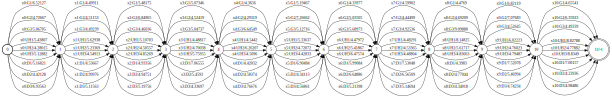

In [21]:
import math
import fst
import random
def ran_lab_prob():
    r = [random.random() for i in range(138)]
    s = sum(r)
    return [i/s for i in r]

t = fst.Transducer()
sym=fst.SymbolTable()
#10 timesteps
#138 labels 
#for i in range(138):
x=0
for j in range(11):
    label_prob = ran_lab_prob()
    labels = ['x','x','x','x','x','x','x','x','x']
    symbols = ['G1','G2','G3','UH1','UH2','UH3','D1','D2','D3']
    #labels=[i for i in range(138)]
    for i in range(9):
        prob =  label_prob[i] #"%.4f" %
        t.add_arc(0+x, 1+x,str(labels[i]+str(j)),symbols[i],-math.log(prob))
    x+=1
t[11].final = -1
t


In [22]:
t2=fst.Transducer()
#3x3 states for this example


symbols = ['G1','G2','G3','UH1','UH2','UH3','D1','D2','D3']
labels  = ['G','UH','D']
x=0
count=0
for i in range(1,10):
    if i%3==1:
        t2.add_arc(0+x,1+x,symbols[x],str(labels[count]+"/"+"("+symbols[x]+")"))
    else:
        t2.add_arc(0+x,1+x,symbols[x],str(sym.find(0)+"("+symbols[x]+")"))
    t2.add_arc(1+x,1+x,symbols[x],str(sym.find(0)+"("+symbols[x]+")"))
    print "i",i
    if i%3==0:
        count+=1
    x+=1
    
t2[9].final=True
# t2


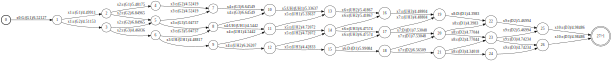

In [23]:
t3 = t>>t2
t3.write("fst.bin")
t3.isyms.write("fst.isysm.bin")
t3.osyms.write("fst.osysm.bin")

t3

In [1]:
import fst
t3 = fst.read("fst.bin")
t3.isyms=fst.read_symbols("fst.isysm.bin")
t3.osyms=fst.read_symbols("fst.osysm.bin")

Best path using api

In [19]:
t= t3.shortest_path()
t

In [19]:
#make parents dict
parents={}
for state in t3.states:
    for arc in state.arcs:
        if arc.nextstate in parents:
            parents[arc.nextstate].append(state.stateid)
        else:
            parents[arc.nextstate]=[state.stateid]
print parents

#ignore
t=t3
for state in t.states:
    for arc in state.arcs:
        print state.stateid,arc.nextstate,\
        t.isyms.find(arc.ilabel),\
        t.osyms.find(arc.olabel),arc.weight

In [8]:
#forward pass
import math
graph=t3
scores ={0:}

def get_key(value):
    for i in range(len(scores)):
        if scores[i]==value:
            return i
def get_max_par(parents):
    if len(parents)!=1:
        if scores[parents[0]] < scores[parents[1]]:
            return parents[1]
        else:
            return parents[0]
    else:
        return parents[0]
    
bestparent={}
bestparent_sym={}
for state in graph.states:
    if state.stateid==0:
        #print "zero",state.stateid
        continue
    else:
        curr_state  = state
        Parents = parents[curr_state.stateid]
        max_par = get_max_par(Parents)
        t = graph[max_par]
        weight=0
        isym=0
        osym=0
        for arc in t.arcs:
            if graph[arc.nextstate].stateid == curr_state.stateid:
                weight=arc.weight
                isym=graph.isyms.find(arc.ilabel)
                osym=graph.osyms.find(arc.olabel)
                #print osym
        #print "curr_state",curr_state.stateid
        #print Parents
        #print "max_par",max_par
        #print "weight",weight
        #print scores[max_par]
        scores[curr_state.stateid]=scores[max_par]+(-math.log(weight))
        bestparent[curr_state.stateid]=max_par
        bestparent_sym[curr_state.stateid]=osym
print scores
print bestparent
#print bestparent_sym

{0: 1, 1: 6.066118509794508, 2: 11.410882404634219, 3: 11.687483483307503, 4: 17.17691026936341, 5: 16.33835277746347, 6: 18.309761474358496, 7: 21.854911247649444, 8: 23.465019222178036, 9: 23.555058447304656, 10: 27.790458197814573, 11: 30.202987127354653, 12: 28.633938843335507, 13: 35.38542179651396, 14: 34.67793446218835, 15: 33.188468058788416, 16: 40.31683867167478, 17: 39.37609552199401, 18: 38.269839943028614, 19: 46.240032479823626, 20: 46.27134064556976, 21: 42.81310009001188, 22: 50.734220185457126, 23: 51.72310945795412, 24: 48.254780696216386, 25: 56.19366746436414, 26: 57.702196830509116, 27: 65.64575211164765}
{1: 0, 2: 1, 3: 1, 4: 2, 5: 3, 6: 3, 7: 4, 8: 6, 9: 6, 10: 8, 11: 9, 12: 9, 13: 11, 14: 11, 15: 12, 16: 13, 17: 14, 18: 15, 19: 16, 20: 17, 21: 18, 22: 20, 23: 20, 24: 21, 25: 23, 26: 23, 27: 26}


In [9]:
state=0
path=[27]
alphas=[]
i=27
while i!=0:
    state=bestparent[i]
    i=state
    path.append(state)
print path
alphas=[scores[p] for p in path]
print alphas

[27, 26, 23, 20, 17, 14, 11, 9, 6, 3, 1, 0]
[65.64575211164765, 57.702196830509116, 51.72310945795412, 46.27134064556976, 39.37609552199401, 34.67793446218835, 30.202987127354653, 23.555058447304656, 18.309761474358496, 11.687483483307503, 6.066118509794508, 1]


In [10]:
#backward pass
bestpath_symbol={}
bestpath_score={}
bestpath_symbol[27]=bestparent_sym[27].encode("utf-8").replace("\xce\xb5","EPS")
bestpath_score[27]=scores[27]
#print bestpath_symbol
for i in reversed(range(1,27)):
    bestpath_symbol[i]=bestparent_sym[i].encode("utf-8").replace("\xce\xb5","EPS")
    bestpath_score[i]=scores[i]
for symb in bestpath_symbol:
    print bestpath_symbol[symb]
#print bestpath_score

G/(G1)
EPS(G1)
EPS(G2)
EPS(G1)
EPS(G2)
EPS(G3)
EPS(G2)
EPS(G3)
UH/(UH1)
EPS(G3)
EPS(UH1)
EPS(UH2)
EPS(UH1)
EPS(UH2)
EPS(UH3)
EPS(UH2)
EPS(UH3)
D/(D1)
EPS(UH3)
D/(D1)
EPS(D2)
EPS(D1)
EPS(D2)
EPS(D3)
EPS(D2)
EPS(D3)
EPS(D3)


In [64]:
y_t_s = {} # dictionary to store probabilities indexed by time and label
n_samps = 10
F = [0]
for t in range(n_samps + 1):
    y_t_s[t] = {}
    for s in F:
        arcs = graph[s].arcs
        for a in arcs:
            osym = graph.osyms.find(a.olabel)
            osym = osym[osym.find("(")+1:osym.find(")")]
            y_t_s[t][osym] = np.exp(-1 * float(a.weight))
    F = map(lambda x: map(lambda y: y.nextstate,graph[x].arcs),F)
    F = set([s for ss in F for s in ss])

In [73]:
#forward pass
import numpy as np
graph=t3
alpha = {}
symbols = ['G1','G2','G3','UH1','UH2','UH3','D1','D2','D3']
def get_key(value):
    for i in range(len(scores)):
        if scores[i]==value:
            return i


for t in range(n_samps + 1):
    alpha[t] = {}
    for i in range(len(symbols)):
        print alpha
        if t == 0:
            if i == 0:
                alpha[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0))
            else:
                alpha[t][symbols[i]] = 0.0
        else:
            if i == 0:
                    alpha[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0)) * alpha[t-1][symbols[i]]
            else:
                alpha[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0)) * (alpha[t-1][symbols[i]] + alpha[t-1][symbols[i-1]])
alpha

{0: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0014717934129675134,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 1: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 1.6364725817911244e-05,
  'G2': 1.6162776269624453e-05,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 2: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 6.811073603014045e-08,
  'G2': 3.4473579868376394e-08,
  'G3': 1.8681306232935016e-07,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 3: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 1.1123746036422873e-09,
  'G3': 1.4220370105751502e-09,
  'UH1': 2.1000080210032426e-09,
  'UH2': 0.0,
  'UH3': 0.0},
 4: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 3.294422563282797e-12,
  'UH1': 3.7434521615554155e-11,
  'UH2': 4.005348351057349e-12,
  'UH3': 0.0},
 5: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 1.9604090430399363e-13,
  'UH2': 3.691790607330902e-13,
  'UH3': 4

In [78]:
# backward pass
graph = t3
beta = {}
symbols = ['G1','G2','G3','UH1','UH2','UH3','D1','D2','D3']
for t in range(n_samps,0,-1):
    beta[t] = {}
    for i in range(len(symbols)):
        if t == n_samps:
            if i == len(symbols) - 1:
                beta[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0))
            else:
                beta[t][symbols[i]] = 0.0
        else:
            if i < len(symbols) - 1:
                score = beta[t+1][symbols[i]] + beta[t+1][symbols[i+1]]
            else:
                score = beta[t+1][symbols[i]]
            beta[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0)) * score
beta        

{1: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 3.234937671111563e-22,
  'G2': 8.677662552511044e-21,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 2: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 4.9862209152181135e-21,
  'G2': 2.4107819575771124e-20,
  'G3': 7.660860414098061e-19,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 3: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 1.1980216761858216e-18,
  'G3': 2.154888057681078e-17,
  'UH1': 4.473169496859423e-17,
  'UH2': 0.0,
  'UH3': 0.0},
 4: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 1.1048277592881657e-16,
  'UH1': 3.2427910070324514e-15,
  'UH2': 7.364628037569548e-16,
  'UH3': 0.0},
 5: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 8.499481323548086e-14,
  'UH2': 2.2010474358696217e-13,
  'UH3': 1.6602341793783255e-13},
 6: {'D1': 6.863103517546181e-12,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2':